# Second deep learning approach: Detection with Faster RCNN in sliding window fashion. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os

# CHANGE ONLY THIS PATH AND EVERYTHING SHOULD RUN
# Vlad's drive
# notebooks_path = Path.cwd()/'drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/notebooks'
# Joaquin's drive
notebooks_path = Path.cwd()/'drive/MyDrive/calcification_detection/calc-det/notebooks'
repo_path = notebooks_path.parent
os.chdir(str(notebooks_path))

thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Move the files to the localhost to run faster

In [2]:
inbreast_pngs_path = str(repo_path / 'data/INbreast\ Release\ 1.0/AllPNGs/full_imgs')
inbreast_img_meta_path = str(repo_path / 'data/INbreast\ Release\ 1.0/images_metadata.csv')
inbreast_rois_meta_path = str(repo_path / 'data/INbreast\ Release\ 1.0/rois_metadata.csv')
inbreast_masks_path = str(repo_path / 'data/INbreast\ Release\ 1.0/AllMasks/full_imgs')

det_checkpoints_path = str(repo_path / 'deep_learning/detection_models/checkpoints/')
class_checkpoints_path = str(repo_path / 'deep_learning/classification_models/checkpoints/')

!mkdir '/home/INbreast Release 1.0/'
!mkdir '/home/INbreast Release 1.0/AllPNGs/'
!mkdir '/home/INbreast Release 1.0/AllMasks/'

!rsync -rva $inbreast_pngs_path '/home/INbreast Release 1.0/AllPNGs/'
!rsync -rva $inbreast_img_meta_path '/home/INbreast Release 1.0/images_metadata.csv'
!rsync -rva $inbreast_rois_meta_path '/home/INbreast Release 1.0/rois_metadata.csv'
!rsync -rva $inbreast_masks_path '/home/INbreast Release 1.0/AllMasks/'

!rsync -rva $det_checkpoints_path '/home/detection_checkpoints'
!mv /home/detection_checkpoints/checkpoints/* '/home/detection_checkpoints/'
!rmdir '/home/detection_checkpoints/checkpoints/'
!rsync -rva $class_checkpoints_path '/home/classification_checkpoints'
!mv /home/classification_checkpoints/checkpoints/* '/home/classification_checkpoints/'
!rmdir '/home/classification_checkpoints/checkpoints/'

!pip install transformers
!pip install SimpleITK

sending incremental file list
full_imgs/
full_imgs/20586908.png
full_imgs/20586934.png
full_imgs/20586960.png
full_imgs/20586986.png
full_imgs/20587054.png
full_imgs/20587080.png
full_imgs/20587148.png
full_imgs/20587174.png
full_imgs/20587200.png
full_imgs/20587226.png
full_imgs/20587294.png
full_imgs/20587320.png
full_imgs/20587346.png
full_imgs/20587372.png
full_imgs/20587466.png
full_imgs/20587492.png
full_imgs/20587518.png
full_imgs/20587544.png
full_imgs/20587612.png
full_imgs/20587638.png
full_imgs/20587664.png
full_imgs/20587690.png
full_imgs/20587758.png
full_imgs/20587784.png
full_imgs/20587810.png
full_imgs/20587836.png
full_imgs/20587902.png
full_imgs/20587928.png
full_imgs/20587994.png
full_imgs/20588020.png
full_imgs/20588046.png
full_imgs/20588072.png
full_imgs/20588138.png
full_imgs/20588164.png
full_imgs/20588190.png
full_imgs/20588216.png
full_imgs/20588308.png
full_imgs/20588334.png
full_imgs/20588458.png
full_imgs/20588510.png
full_imgs/20588536.png
full_imgs/205885

Generate the database of images in the validation set

In [2]:
from database.dataset import INBreast_Dataset

db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['validation'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)

### Create a function to get the detection over a complete dataset

In [3]:
import pickle
import time
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria

def get_froc_dataframe_from_set(db, detector, results_path, store_time = False, multiscale=False):
    # get normal images
    normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

    # define paths to store intermediate results
    results_path = Path(results_path)
    if not results_path.exists():
        results_path.mkdir(parent=True, exist_ok=True)
    frocs_df_path = results_path / 'froc_df.csv'
    times_path = results_path / 'times.p'
    froc_dfs = []
    times = []

    # get the detections for each image in the database
    for idx in tqdm(range(len(db))):
        # get sample
        db_sample = db[idx]
        image = db_sample['img']
        image_id = db_sample['img_id']
        image_mask = db_sample['lesion_mask']

        start = time.time()
        detections = detector.detect(image)
        times.append(time.time()-start)

        # reformat detections
        detections_centers = detections[:, 0:2].astype(int)
        detections_scores = detections[:, -1].reshape(-1, 1)
        detections_radius = np.ones(detections_scores.shape) * 7
        # retain the centers and scores:
        candidates = np.concatenate(
            [detections_centers, detections_radius, detections_scores], axis = 1)

        # compare with labels
        tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # generate standard dataframe
        froc_df = get_froc_df_of_img(
            candidates, fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
        
        froc_dfs.append(froc_df)
    
    # store full
    froc_dfs = pd.concat(froc_dfs, ignore_index=True)
    froc_dfs.to_csv(frocs_df_path)
    if store_time:
        with open(times_path, 'wb') as f:
            pickle.dump(times, f)
    return froc_dfs

In [4]:
from deep_learning.dl_utils import get_model_from_checkpoint
from deep_learning.detection_models.models.detect_based_detector import DetectionBasedDetector
from general_utils.plots import plot_froc, plot_several_frocs, add_detections_overlay
from metrics.metrics import froc_curve
from metrics.metrics_utils import best_th_froc_curve
import general_utils.utils as utils
import cv2
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None 

### Best model using pretrained resnet 50 (Faster RCNN - d_resnet50_00)

In [6]:
# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mdl_ckpt = torch.load('/home/detection_checkpoints/d_resnet50_00.pt')
mdl_ckpt['configuration']['model']['checkpoint_path'] = \
    '/home/classification_checkpoints/224_resnet50_05.pt'

detector = DetectionBasedDetector(
    model_chkp=mdl_ckpt,
    patch_size=224,
    stride=200,
    min_breast_fraction_patch=0.7,
    batch_size=28,
    bbox_size=14,
    device=device,
    iou_threshold=0.5
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
results_path = repo_path.parent / 'detections_dl/d_resnet50_00'
froc_dfs = get_froc_dataframe_from_set(db, detector, results_path, store_time = False)

100%|██████████| 62/62 [05:13<00:00,  5.06s/it]


Distribution of labels among detections

In [8]:
froc_dfs.label.value_counts()

FP    15879
TP      852
FN       61
Name: label, dtype: int64

### FROC CURVE

Threshold: 0.8870506882667542, TPR: 0.8685446009389671, FPR: 1.4838709677419355


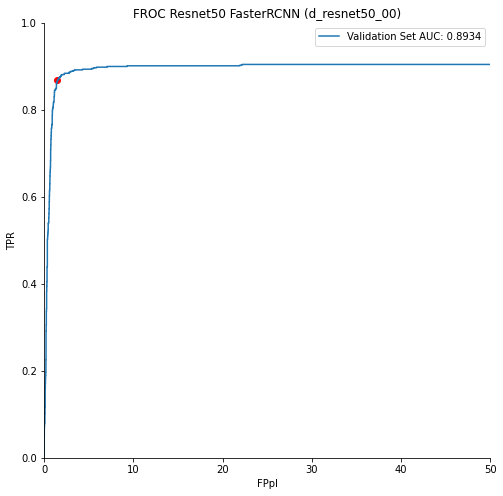

In [9]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')
sens.append(sens[-1])
avgs_fp_per_image.append(50)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Validation Set', title='FROC Resnet50 FasterRCNN (d_resnet50_00)', ax=ax)

### Visualization of detections

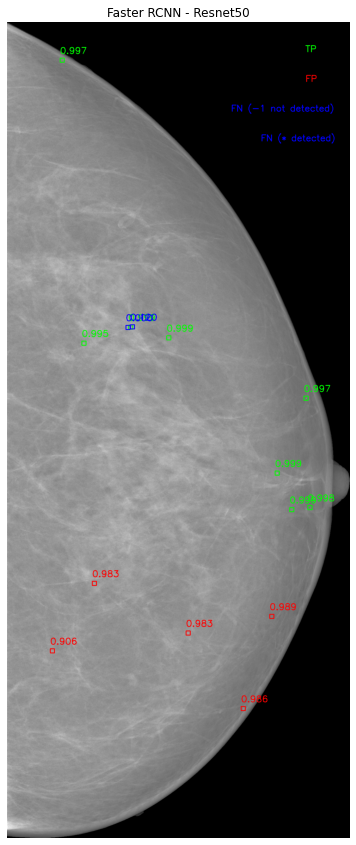

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
mdl_ckpt = torch.load('/home/detection_checkpoints/d_resnet50_00.pt')
mdl_ckpt['configuration']['model']['checkpoint_path'] = \
    '/home/classification_checkpoints/224_resnet50_05.pt'

# detectors instatiation
detector = DetectionBasedDetector(
    model_chkp=mdl_ckpt,
    patch_size=224,
    stride=200,
    min_breast_fraction_patch=0.7,
    batch_size=28,
    bbox_size=14,
    device=device,
    iou_threshold=0.5
)

# get image
idx = 22
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

# get detections
detections = detector.detect(image)

# reformat detections
detections_centers = detections[:, 0:2].astype(int)
detections_scores = detections[:, -1].reshape(-1, 1)
detections_radius = np.ones(detections_scores.shape) * 7
detections = np.concatenate(
    [detections_centers, detections_radius, detections_scores], axis = 1)

# Generate the images
image = add_detections_overlay(
    image, detections, image_mask, conf_thr=0.8870506882667542, k=0, need_labeling = True)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
ax.set_title('Faster RCNN - Resnet50')
ax.imshow(image)
ax.axis('off')
plt.show()

# Example on how to store the detections as dcm image

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
mdl_ckpt = torch.load('/home/detection_checkpoints/d_resnet50_00.pt')
mdl_ckpt['configuration']['model']['checkpoint_path'] = \
    '/home/classification_checkpoints/224_resnet50_05.pt'

# detectors instatiation
detector = DetectionBasedDetector(
    model_chkp=mdl_ckpt,
    patch_size=224,
    stride=200,
    min_breast_fraction_patch=0.7,
    batch_size=28,
    bbox_size=14,
    device=device,
    iou_threshold=0.5,
    score_threshold=0.8870506882667542
)

# get image
idx = 22
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

# get detections
detections = detector.detect(image)

# reformat detections
detections_centers = detections[:, 0:2].astype(int)
detections_scores = detections[:, -1].reshape(-1, 1)
detections_radius = np.ones(detections_scores.shape) * 7
detections = np.concatenate(
    [detections_centers, detections_radius, detections_scores], axis = 1)

fields = ['img_id', 'case_id', 'side', 'view', 'breast_bbox']
fields = db.img_df.loc[db.img_df.img_id == image_id, fields].values[0]
view = 'ML' if fields[3] == 'MLO' else fields[3]
dcm_img_name = f'{fields[0]}_{fields[1]}_MG_{fields[2]}_{view}_ANON.dcm'
dcm_path = repo_path / 'data/INbreast Release 1.0/AllDICOMs/'
original_dcm_filepath = dcm_path/dcm_img_name
breast_bbox = fields[-1]

output_filepath = repo_path.parent / 'example_fasterrcnn.dcm'

detections_df = pd.DataFrame(detections, columns=['x', 'y', 'radius', 'score'])
utils.store_as_dcm(
    image, detections_df, original_dcm_filepath, output_filepath, breast_bbox)


## Comparison of FROCS

In [ ]:
# base_path = '/content/drive/MyDrive/calcification_detection/detections_dl'
# models = ['16_net2_07', '32_net2_05', '64_net2_03', '224_resnet50_05',
#           'multiscale_16_32_64','multiscale_16_32','multiscale_16_32_max']
# frocs = {}
# for model in tqdm(models):
#     path = Path(base_path)/model
#     froc_df = pd.read_csv(path/'froc_df.csv')
#     tprs, fpis, ths = froc_curve(froc_df, cut_on_50fpi=True)
#     if '224' in model:
#         tprs.append(tprs[-1])
#         fpis.append(50)
#     name = model.split('_')[0]
#     name = model if (name == 'multiscale') else f'{name}x{name}'
#     frocs[name] = {'tprs': tprs, 'fpis': fpis, 'ths': ths}

# plot_several_frocs(frocs, title='FROC - Comparison', cut_on_50fpi=True)

## Comparison of Time

In [ ]:
# base_path = '/content/drive/MyDrive/calcification_detection/detections_dl'
# models = ['16_net2_07', '32_net2_05', '64_net2_03', '224_resnet50_05']
# times = {}
# for model in tqdm(models):
#     path = Path(base_path)/model/'times.p'
#     with open(path, 'rb') as f:
#         time = pickle.load(f)
#     name = model.split('_')[0]
#     name = f'{name}x{name}'
#     times[name] = time
# times = pd.DataFrame(times)
# times['multiscale_16_32_64'] = times['16x16'] + times['32x32'] + times['64x64']
# times['multiscale_16_32'] = times['16x16'] + times['32x32']
# plt.figure(figsize=(12,5))
# plt.title('Computation time per image in validation set')
# plt.ylabel('Time [s]')
# plt.ylim([0, 200])
# plt.xlabel('Model')
# sns.boxplot(x="variable", y="value", data=pd.melt(times))
# sns.despine()